# EXPERIMENT SETUP #1 - Pre-processing

The first step in any machine learning problem is to understand and clean the data as necessary. That is what this notebook is concerned with. Testing out multiple NLP data preprocessing techiniques to get the most information out of the dataset.

[This](https://stackoverflow.com/questions/63979544/using-trained-bert-model-and-data-preprocessing) thread argues that due to the nature of BERT conventional preprocessing techniques like stemming, lemmatization etc should have very minimal or no effect on BERT.

Having said that, [this](https://datascience.stackexchange.com/questions/62862/preprocessing-for-text-classification-in-transformer-models-bert-variants) stackexchange thread suggests there might be differences especially when you consider different datasets and suggests to try it out and do what works for you.

Even though the argument in the first thread makes sense, I feel it's worthwhile to do the experiment and see for myself the change or no change pre-processing would have.


### Data Splitting
Since the training methodology can be kfold or test train splitting, the project has split the initial dataset into 2 files, data.csv(used in both kfold and test train) and val.csv(which will never be used in test train or kfold and will only be used in the evaluation step).

However, since the dataset is imbalanced, the records belonging to Quantitative Biology,Quantitative Finance are duplicated in both data.csv and val.csv

The code used for splitting the dataset is

```python
data = pd.read_csv("data/train.csv")
test = data[
           (data["Computer Science"] == 1) | (data["Physics"] == 1) |
           (data["Statistics"] == 1) | (data["Mathematics"] == 1) &
           (data["Quantitative Biology"] == 0) & (data["Quantitative Finance"] == 0)
           ].iloc[:1000, :]
data = data[~data["ID"].isin(test["ID"])]
print(data.shape)
minority = data[(data["Quantitative Biology"] == 1) | (data["Quantitative Finance"] == 1)]
test = pd.concat([test, minority])
print(test.shape)

test.to_csv("val.csv", index=False)
data.to_csv("data.csv", index=False)
```

The data distribution is

| Class  |  Count |
|---|---|
| Computer Science   |  8164 |
| Physics  | 5721  |
| Mathematics  | 5338  |
| Statistics  | 4959  |
| Quantitative Biology  | 577  |
| Quantitative Finance  |  247 |

The validation distribution is

| Class  |  Count |
|---|---|
| Computer Science   |  471 |
| Physics  | 292  |
| Mathematics  | 279  |
| Statistics  | 376  |
| Quantitative Biology  | 587  |
| Quantitative Finance  |  248 |

## Load Data

In [1]:
!pip install transformers nltk

     |████████████████████████████████| 2.1MB 6.7MB/s 
     |████████████████████████████████| 3.3MB 27.0MB/s 
     |████████████████████████████████| 901kB 49.6MB/s 


The project uses the huggingface transformers module to work with BERT. The project has another wrapper around hugging face to make experimentation easier. Relevant part of the wrapper modules will be documented in the notebook itself.

```python
class Model(abc.ABC):

    def __init__(self, *, config, version="1"):
        self.model = None
        self.config = config
        self.version = version
        self.data_processor = None
        self.tokenizer = None

    @abc.abstractmethod
    def build(self, processors):
        pass

    def build_data_processor(self, processors):
        self.data_processor = DataProcessor(self.tokenizer, processors=processors, max_length=self.config.max_length)
        return self.data_processor

    @abc.abstractmethod
    def predict(self, x):
        pass

    @staticmethod
    def _prepare(data, ids=None, from_bert_encoded=True):
        if from_bert_encoded:
            data["input_ids"] = np.array(data["input_ids"])
            data["token_type_ids"] = np.array(data["token_type_ids"])
            data["attention_mask"] = np.array(data["attention_mask"])
        if ids is not None:
            return [
                data['input_ids'][ids],
                data['token_type_ids'][ids],
                data['attention_mask'][ids]
            ]
        else:
            return [
                data['input_ids'],
                data['token_type_ids'],
                data['attention_mask']
            ]

    def train(self, train_x, train_y, test_x, test_y, config):
        training_history = self.model.fit(
            x=train_x, y=train_y,
            epochs=config.epochs, batch_size=config.batch_size,
            validation_data=(test_x, test_y)
        )
        return training_history

    def name(self):
        return "{}_{}".format(self.__class__.__name__, self.version)

    def save(self, directory, version=None):
        model_name = "{}_{}".format(self.name(), version) if version else self.name()
        self.model.save_weights(os.path.join(directory, model_name), save_format="h5")

    def load(self, directory, version=None):
        model_name = "{}_{}".format(self.name(), version) if version else self.name()
        self.model.load_weights(os.path.join(directory, model_name))
```

This the abstract BERT class, which will be extended to create several different implementations of BERT and will help with setting up multiple experiments. All of the BERT implementations will extend from this base class.

In [2]:
import pandas as pd
%matplotlib inline
import numpy as np
import tensorflow as tf
from google.colab import drive
import os
import bert
import trainer
import utils
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import json

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

In [3]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [4]:
drive.mount('/gdrive')
os.listdir('/gdrive/MyDrive/data')

Mounted at /gdrive


['test.csv',
 'sample_submission.csv',
 'train.csv',
 'saved_models',
 'training_resultsSimpleBertForSequenceClassification.json',
 'training_resultsModifiedBertForSequenceClassification.json',
 'utils.py',
 'trainer.py',
 'bert.py',
 'training_results_ModifiedBertForSequenceClassification.json',
 'training_results_ModifiedBertForSequenceClassification_1.json',
 'training_results_BertToSingleLayerNeuralNetwork_1.json',
 'training_results_SimpleBertForSequenceClassification_1.json',
 'preprocessing_exp',
 'tokenizer_exp',
 'val.csv',
 'data.csv',
 'hyperparameter_exp',
 'training_exp',
 'final']

In [5]:
dataset_location = '/gdrive/MyDrive/data'
path = "/gdrive/MyDrive/data/preprocessing_exp"
use_tpu = True
train = True

In [6]:
if not os.path.exists(path):
    os.mkdir(path)

In [7]:
dataset = pd.read_csv("{}/data.csv".format(dataset_location))
validation_dataset = pd.read_csv("{}/val.csv".format(dataset_location))

In [8]:
dataset.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,10,$\mathcal{R}_{0}$ fails to predict the outbrea...,Time varying susceptibility of host at indiv...,0,0,0,0,1,0
1,21,Deciphering noise amplification and reduction ...,The impact of random fluctuations on the dyn...,0,0,0,0,1,0
2,34,An Unsupervised Homogenization Pipeline for Cl...,Electronic health records (EHR) contain a la...,0,0,0,0,1,0
3,42,Are multi-factor Gaussian term structure model...,"In this paper, we empirically study models f...",0,0,0,0,0,1
4,56,Competing evolutionary paths in growing popula...,Investigating the emergence of a particular ...,0,0,0,0,1,0


### Combining fields

To get the most amount of information the "Title" and "Abstract" were combind to form the input for our model.


In [9]:
dataset["text"] = dataset["TITLE"] + " ." + dataset["ABSTRACT"]
validation_dataset["text"] = validation_dataset["TITLE"] + " ." + validation_dataset["ABSTRACT"]
dataset.head(1)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
0,10,$\mathcal{R}_{0}$ fails to predict the outbrea...,Time varying susceptibility of host at indiv...,0,0,0,0,1,0,$\mathcal{R}_{0}$ fails to predict the outbrea...


In [10]:
classes = ["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]

In [11]:
Y = dataset[classes].values
Y_val = validation_dataset[classes].values

In [12]:
if use_tpu:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    except ValueError:
        strategy = tf.distribute.get_strategy() # for CPU and single GPU
        print('Number of replicas:', strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.96.43.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.96.43.154:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Train
#### Model config & Trainer Config
Model Config and Trainer Config objects are used by the wrapper module to build and train the models.

The learning rate, optimizer, loss functions choice reasons can be found in the Experiment Setup #4

In [13]:
class ModelConfig:
    max_length = 100
    bert_name = "bert-base-uncased"
    num_labels = 6
    optimizer = tf.keras.optimizers.Adam(0.00001)
    loss_function = "binary_crossentropy"
    metrics = ["accuracy"]


class TrainerConfig:
    test_size = 0.2
    fold_count = 8
    batch_size = 64
    epochs = 10

#### Baseline

Up until experiment #3 the following is the choice of model to keep all the other variable in check.

```python
    def build(self, processors=None):
        if processors is None:
            processors = []
        self.tokenizer = BertTokenizer.from_pretrained(self.config.bert_name)
        self.data_processor = self.build_data_processor(processors=processors)
        self.model = TFBertForSequenceClassification.from_pretrained(self.config.bert_name,
                                                                     num_labels=self.config.num_labels)
        self.model.compile(optimizer=self.config.optimizer, loss=self.config.loss_function, metrics=self.config.metrics)
        return self
```

The first experiment is to get a baseline performance of our model. We will pass the raw text with out any preprocessing to the model and see what BERT can do with it.

The processors list in the first line of the cell defines a rudmentary pipeline of sort which is passed to the build method of the model class. The model class internally maintans a data processor object. which takes care of the tokenization and runs the processor pipeline. Each element of the processor pipeline is a callable that takes a pandas series as input and does some prepocessing operation.

In [14]:
processors = []
version = "bland_1"
if use_tpu:
    with strategy.scope():
        model_bland = bert.SimpleBertForSequenceClassification(config=ModelConfig)
        model_bland.version = version
        model_bland.build(processors=processors)
else:
    model_bland = bert.SimpleBertForSequenceClassification(config=ModelConfig)
    model_bland.version = version
    model_bland.build(processors=processors)
if train:
    trainer_methodology = trainer.TestTrainSplitTrainer(config=TrainerConfig, model=model_bland)
    trainer_methodology.initialize(x=dataset["text"], y=Y)
    training_history_bland = trainer_methodology.train()
    training_history_bland = utils.training_history_to_dict(training_history_bland)
    with open(os.path.join(path, "training_results_{}.json".format(model_bland.name())), "w") as file:
        json.dump(training_history_bland, file)
    model_bland.save(path)
else:
    model_bland.load(path)
    with open(os.path.join(path, "training_results_{}.json".format(model_bland.name())), "r") as file:
        training_history_bland = json.load(file)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


250/250 [==============================] - ETA: 0s - loss: 0.6752 - accuracy: 0.5222WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


250/250 [==============================] - 204s 330ms/step - loss: 0.6743 - accuracy: 0.5227 - val_loss: 0.3084 - val_accuracy: 0.7542
Epoch 2/10
250/250 [==============================] - 26s 103ms/step - loss: 0.2987 - accuracy: 0.7527 - val_loss: 0.2790 - val_accuracy: 0.7605
Epoch 3/10
250/250 [==============================] - 26s 103ms/step - loss: 0.2716 - accuracy: 0.7487 - val_loss: 0.3118 - val_accuracy: 0.7084
Epoch 4/10
250/250 [==============================] - 26s 103ms/step - loss: 0.2729 - accuracy: 0.7413 - val_loss: 0.2533 - val_accuracy: 0.7329
Epoch 5/10
250/250 [==============================] - 26s 103ms/step - loss: 0.3503 - accuracy: 0.6199 - val_loss: 0.4055 - val_accuracy: 0.7337
Epoch 6/10
250/250 [==============================] - 26s 103ms/step - loss: 0.3136 - accuracy: 0.6964 - val_loss: 0.2662 - val_accuracy: 0.7542
Epoch 7/10
250/250 [==============================] - 26s 103ms/step - loss: 0.4267 - accuracy: 0.5916 - val_loss: 0.3056 - val_accuracy: 0.

#### Replacing latex equation with the word equation.

The idea is that removing the equation altogether means we are loosing information. Instead replacing latex equation with the word equation might prove more useful as we are condensing the information to a single word.

Following the function used to perform the operation.

```python
def replace_latex_math_with(abstract):
    abstract = abstract.strip()
    is_equation = False
    results = abstract.split("$")
    for index, result in enumerate(results):
        if is_equation:
            results[index] = "equation"
        is_equation = not is_equation
    results = " ".join(results)
    starting_index = results.find("\\begin{equation}")
    if starting_index != -1:
        ending_index = results.find("\\end{equation}") + len("\\end{equation}")
        results = results[:starting_index] + " equation " + results[ending_index + 1:]
    return results
```

In [15]:
processors = [utils.replace_latex_math_with]
version = "equation_1"
if use_tpu:
    with strategy.scope():
        model_with_equation_replacement = bert.SimpleBertForSequenceClassification(config=ModelConfig)
        model_with_equation_replacement.version = version
        model_with_equation_replacement.build(processors=processors)
else:
    model_with_equation_replacement = bert.SimpleBertForSequenceClassification(config=ModelConfig)
    model_with_equation_replacement.version = version
    model_with_equation_replacement.build(processors=processors)
if train:
    trainer_methodology = trainer.TestTrainSplitTrainer(config=TrainerConfig, model=model_with_equation_replacement)
    trainer_methodology.initialize(x=dataset["text"], y=Y)
    training_history_equation = trainer_methodology.train()
    training_history_equation = utils.training_history_to_dict(training_history_equation)
    with open(os.path.join(path, "training_results_{}.json".format(model_with_equation_replacement.name())), "w") as file:
        json.dump(training_history_equation, file)
    model_with_equation_replacement.save(path)
else:
    model_with_equation_replacement.load(path)
    with open(os.path.join(path, "training_results_{}.json".format(model_with_equation_replacement.name())), "r") as file:
        training_history_equation = json.load(file)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


250/250 [==============================] - ETA: 0s - loss: 1.1214 - accuracy: 0.3678WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


250/250 [==============================] - 158s 323ms/step - loss: 1.1196 - accuracy: 0.3684 - val_loss: 0.3317 - val_accuracy: 0.7254
Epoch 2/10
250/250 [==============================] - 26s 103ms/step - loss: 0.3716 - accuracy: 0.6701 - val_loss: 0.2811 - val_accuracy: 0.7439
Epoch 3/10
250/250 [==============================] - 26s 104ms/step - loss: 0.3020 - accuracy: 0.7239 - val_loss: 0.3354 - val_accuracy: 0.6743
Epoch 4/10
250/250 [==============================] - 26s 103ms/step - loss: 0.3195 - accuracy: 0.7235 - val_loss: 0.2678 - val_accuracy: 0.6976
Epoch 5/10
250/250 [==============================] - 26s 103ms/step - loss: 0.2467 - accuracy: 0.7420 - val_loss: 0.2575 - val_accuracy: 0.7417
Epoch 6/10
250/250 [==============================] - 26s 103ms/step - loss: 0.3127 - accuracy: 0.6913 - val_loss: 0.2703 - val_accuracy: 0.7447
Epoch 7/10
250/250 [==============================] - 26s 104ms/step - loss: 0.2629 - accuracy: 0.7610 - val_loss: 0.3122 - val_accuracy: 0.

#### Stemming the input
This experiment tries to stem the input before using it to train the model. The pipeline in this experiment has 3 callables. The replace_latex_math_with that replaces the math equation and the to_corpus method that converts the string into a list of words to make stemming easier and then finally the stemming method.

In [16]:
processors = [utils.replace_latex_math_with, utils.to_corpus, utils.stem_sentence]
version = "stemm_1"
if use_tpu:
    with strategy.scope():
        model_with_stemming = bert.SimpleBertForSequenceClassification(config=ModelConfig)
        model_with_stemming.version = version
        model_with_stemming.build(processors=processors)
else:
    model_with_stemming = bert.SimpleBertForSequenceClassification(config=ModelConfig)
    model_with_stemming.version = version
    model_with_stemming.build(processors=processors)
if train:
    trainer_methodology = trainer.TestTrainSplitTrainer(config=TrainerConfig, model=model_with_stemming)
    trainer_methodology.initialize(x=dataset["text"], y=Y)
    training_history_stemm = trainer_methodology.train()
    training_history_stemm = utils.training_history_to_dict(training_history_stemm)
    with open(os.path.join(path, "training_results_{}.json".format(model_with_stemming.name())), "w") as file:
        json.dump(training_history_stemm, file)
    model_with_stemming.save(path)
else:
    model_with_stemming.load(path)
    with open(os.path.join(path, "training_results_{}.json".format(model_with_stemming.name())), "r") as file:
        training_history_stemm = json.load(file) 

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


250/250 [==============================] - ETA: 0s - loss: 1.3394 - accuracy: 0.2933WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


250/250 [==============================] - 161s 331ms/step - loss: 1.3388 - accuracy: 0.2936 - val_loss: 1.0825 - val_accuracy: 0.5242
Epoch 2/10
250/250 [==============================] - 26s 104ms/step - loss: 1.0870 - accuracy: 0.4870 - val_loss: 1.0396 - val_accuracy: 0.5429
Epoch 3/10
250/250 [==============================] - 26s 104ms/step - loss: 1.0441 - accuracy: 0.5283 - val_loss: 1.0138 - val_accuracy: 0.5532
Epoch 4/10
250/250 [==============================] - 26s 103ms/step - loss: 1.0148 - accuracy: 0.5354 - val_loss: 0.9946 - val_accuracy: 0.4899
Epoch 5/10
250/250 [==============================] - 26s 104ms/step - loss: 1.0340 - accuracy: 0.4997 - val_loss: 1.0074 - val_accuracy: 0.5076
Epoch 6/10
250/250 [==============================] - 26s 104ms/step - loss: 0.8974 - accuracy: 0.5603 - val_loss: 0.3567 - val_accuracy: 0.7229
Epoch 7/10
250/250 [==============================] - 26s 104ms/step - loss: 0.3461 - accuracy: 0.7307 - val_loss: 0.3108 - val_accuracy: 0.

#### Lemmatizing the input
This experiment tries to lemmatize the input before using it to train the model. The pipeline in this experiment has 3 callables. The replace_latex_math_with that replaces the math equation and the to_corpus method that converts the string into a list of words to make lemmatizing easier and then finally the lemmatize method.

In [18]:
processors = [utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence]
version = "lemm_1"
if use_tpu:
    with strategy.scope():
        model_with_lemmatization = bert.SimpleBertForSequenceClassification(config=ModelConfig)
        model_with_lemmatization.version = version
        model_with_lemmatization.build(processors=processors)
else:
    model_with_lemmatization = bert.SimpleBertForSequenceClassification(config=ModelConfig)
    model_with_lemmatization.version = version
    model_with_lemmatization.build(processors=processors)
if train:
    trainer_methodology = trainer.TestTrainSplitTrainer(config=TrainerConfig, model=model_with_lemmatization)
    trainer_methodology.initialize(x=dataset["text"], y=Y)
    training_history_lemm = trainer_methodology.train()
    training_history_lemm = utils.training_history_to_dict(training_history_lemm)
    with open(os.path.join(path, "training_results_{}.json".format(model_with_lemmatization.name())), "w") as file:
        json.dump(training_history_lemm, file)
    model_with_lemmatization.save(path)
else:
    model_with_lemmatization.load(path)
    with open(os.path.join(path, "training_results_{}.json".format(model_with_lemmatization.name())), "r") as file:
        training_history_lemm = json.load(file) 

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


250/250 [==============================] - ETA: 0s - loss: 0.5161 - accuracy: 0.5399WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


250/250 [==============================] - 162s 330ms/step - loss: 0.5158 - accuracy: 0.5403 - val_loss: 0.3714 - val_accuracy: 0.7587
Epoch 2/10
250/250 [==============================] - 26s 103ms/step - loss: 0.3536 - accuracy: 0.7497 - val_loss: 0.3580 - val_accuracy: 0.6856
Epoch 3/10
250/250 [==============================] - 26s 104ms/step - loss: 0.3334 - accuracy: 0.7187 - val_loss: 0.4306 - val_accuracy: 0.4804
Epoch 4/10
250/250 [==============================] - 26s 105ms/step - loss: 0.3831 - accuracy: 0.6465 - val_loss: 0.2953 - val_accuracy: 0.7474
Epoch 5/10
250/250 [==============================] - 26s 104ms/step - loss: 0.2858 - accuracy: 0.7516 - val_loss: 0.3560 - val_accuracy: 0.7099
Epoch 6/10
250/250 [==============================] - 26s 104ms/step - loss: 0.3253 - accuracy: 0.7451 - val_loss: 0.2846 - val_accuracy: 0.7605
Epoch 7/10
250/250 [==============================] - 26s 104ms/step - loss: 0.2707 - accuracy: 0.7709 - val_loss: 0.3403 - val_accuracy: 0.

# Evaluation

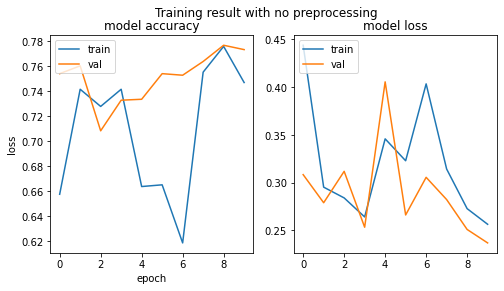

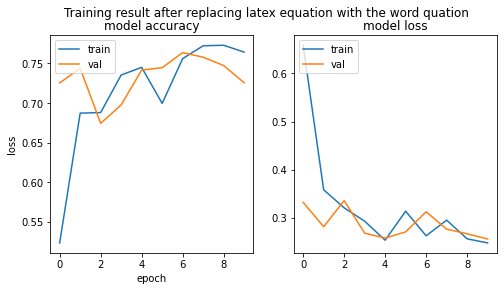

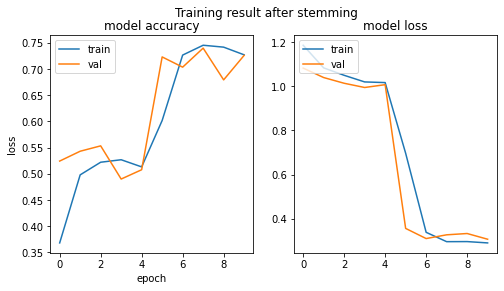

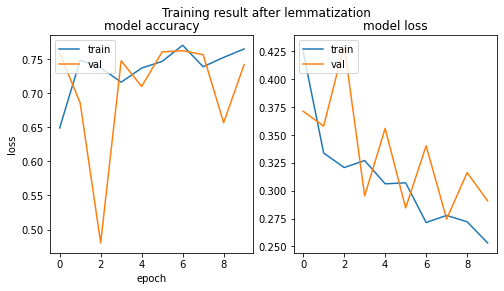

In [19]:
model = bert.SimpleBertForSequenceClassification(config=ModelConfig)
model.version = "bland_1"
with open(os.path.join(path, "training_results_{}.json".format(model.name())), "r") as file:
    training_history = json.load(file)
utils.plot_training_result(training_history, "Training result with no preprocessing")


model.version = "equation_1"
with open(os.path.join(path, "training_results_{}.json".format(model.name())), "r") as file:
    training_history = json.load(file)
utils.plot_training_result(training_history, "Training result after replacing latex equation with the word quation")


model.version = "stemm_1"
with open(os.path.join(path, "training_results_{}.json".format(model.name())), "r") as file:
    training_history = json.load(file)
utils.plot_training_result(training_history, "Training result after stemming")


model.version = "lemm_1"
with open(os.path.join(path, "training_results_{}.json".format(model.name())), "r") as file:
    training_history = json.load(file)
utils.plot_training_result(training_history, "Training result after lemmatization")

## Training history
From the training history graph the the last experiment seemed to be the most stable, this is ofcourse bearing in mind the fact that more run of the experiment is needed to make a confident statement. But with the limitations in mind, lets say replacing latex equations with equation and lemmatizing is the right combination.

In [21]:
model = bert.SimpleBertForSequenceClassification(config=ModelConfig)
model.build(processors=[])
model.version = "bland_1"
model.load(path)
bland_y_pred = model.predict(validation_dataset["text"])


model.build(processors=[utils.replace_latex_math_with])
model.version = "equation_1"
model.load(path)
equation_y_pred = model.predict(validation_dataset["text"])


model.build(processors=[utils.replace_latex_math_with, utils.to_corpus, utils.stem_sentence])
model.version = "stemm_1"
model.load(path)
stemm_y_pred = model.predict(validation_dataset["text"])


model.build(processors=[utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence])
model.version = "lemm_1"
model.load(path)
lemm_y_pred = model.predict(validation_dataset["text"])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model 

## Evaluation metrics
The following metrics were chosen to calculate the performance of the model

* f1-score - This was chosen since is the ideal metric to inform us about the balance between precision and recall of a model.

* Hamming Loss - This choice was inspired from this [article](https://www.linkedin.com/pulse/hamming-score-multi-label-classification-chandra-sharat). Hamming loss is a popular metric for multilabel classification as it can indicate the fraction of incorrect labels to the total number of labels.

* Confusion matrix - This choice was made to simply get a look at the False positives, true positives, false negatives and false positives. Which always tells a great deal about the models performance.

* ROC Curve - The ROC curve can be used to understand the tradeoff between true positive rate and false positive rate. Its very easy to infer performance of an ROC Curve. the following graph shows how to infer an ROC Curve.

In [22]:
exp_names = ["No Preprocessing", "Replacing latex equations", "Stemming", "Lemmatizing"]

In [23]:
y_preds=[bland_y_pred, equation_y_pred, stemm_y_pred, lemm_y_pred]
Ys=[Y_val, Y_val, Y_val, Y_val]
classes=classes
threshold=0.5
model_names=exp_names

In [24]:
utils.print_f1_scores(y_preds, Ys, classes, threshold, model_names)

F1-Score for is  No Preprocessing : [('Computer Science', 0.4523239099185434), ('Physics', 0.32132963988919666), ('Mathematics', 0.29195524773574855), ('Statistics', 0.39704329461457233), ('Quantitative Biology', 0.88099173553719), ('Quantitative Finance', 0.864)]
F1-Score for is  Replacing latex equations : [('Computer Science', 0.4852941176470589), ('Physics', 0.29486527707168275), ('Mathematics', 0.42466822794691655), ('Statistics', 0.4286539572501444), ('Quantitative Biology', 0.8805620608899297), ('Quantitative Finance', 0.0)]
F1-Score for is  Stemming : [('Computer Science', 0.47864127637673703), ('Physics', 0.35051546391752575), ('Mathematics', 0.42513576415826215), ('Statistics', 0.42832667047401485), ('Quantitative Biology', 0.0), ('Quantitative Finance', 0.8897637795275591)]
F1-Score for is  Lemmatizing : [('Computer Science', 0.4923076923076924), ('Physics', 0.33977738722905687), ('Mathematics', 0.35378590078328986), ('Statistics', 0.4509090909090909), ('Quantitative Biology

In [25]:
utils.print_hamming_losses(y_preds, Ys, classes, threshold, model_names)

Hamming for No Preprocessing  :  0.46178460413238254
Hamming for Replacing latex equations  :  0.4109526421649296
Hamming for Stemming  :  0.408575607972207
Hamming for Lemmatizing  :  0.42558054488937647


Confusion matrix for No Preprocessing


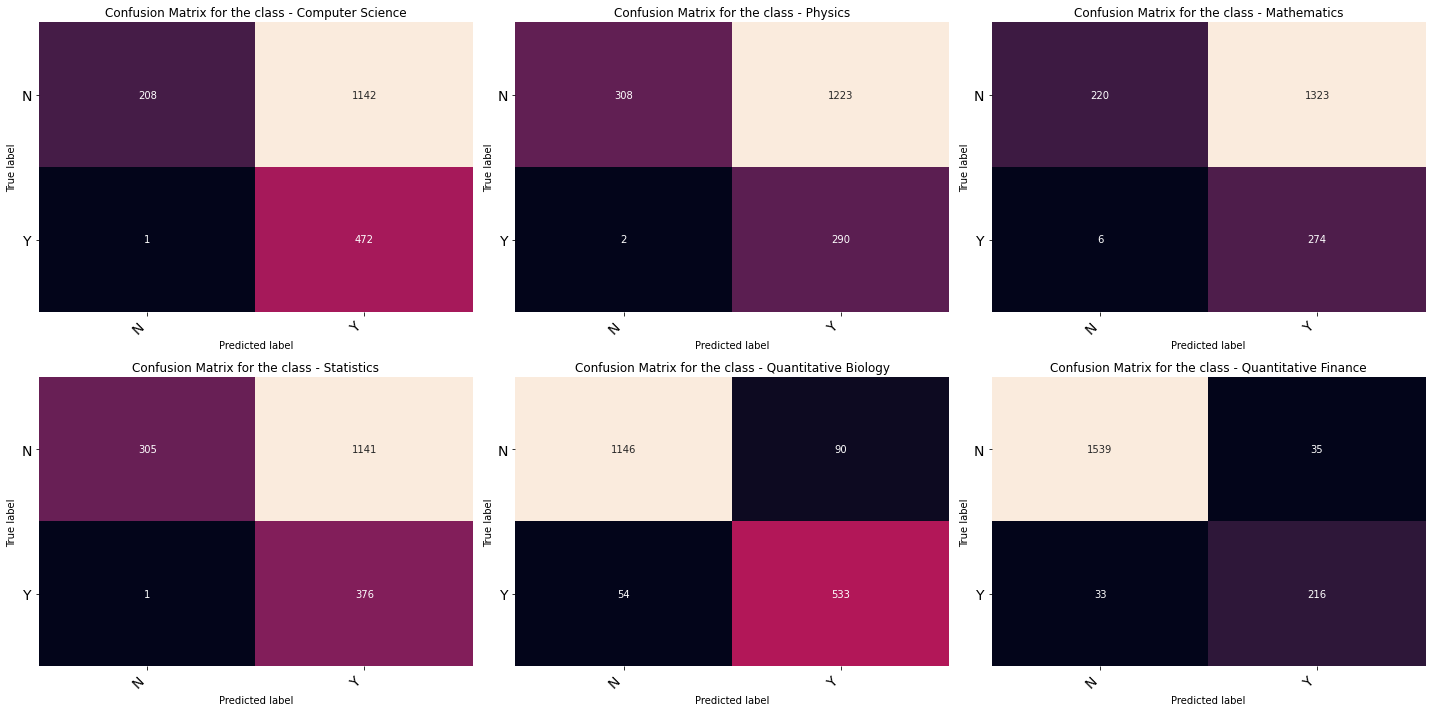

Confusion matrix for Replacing latex equations


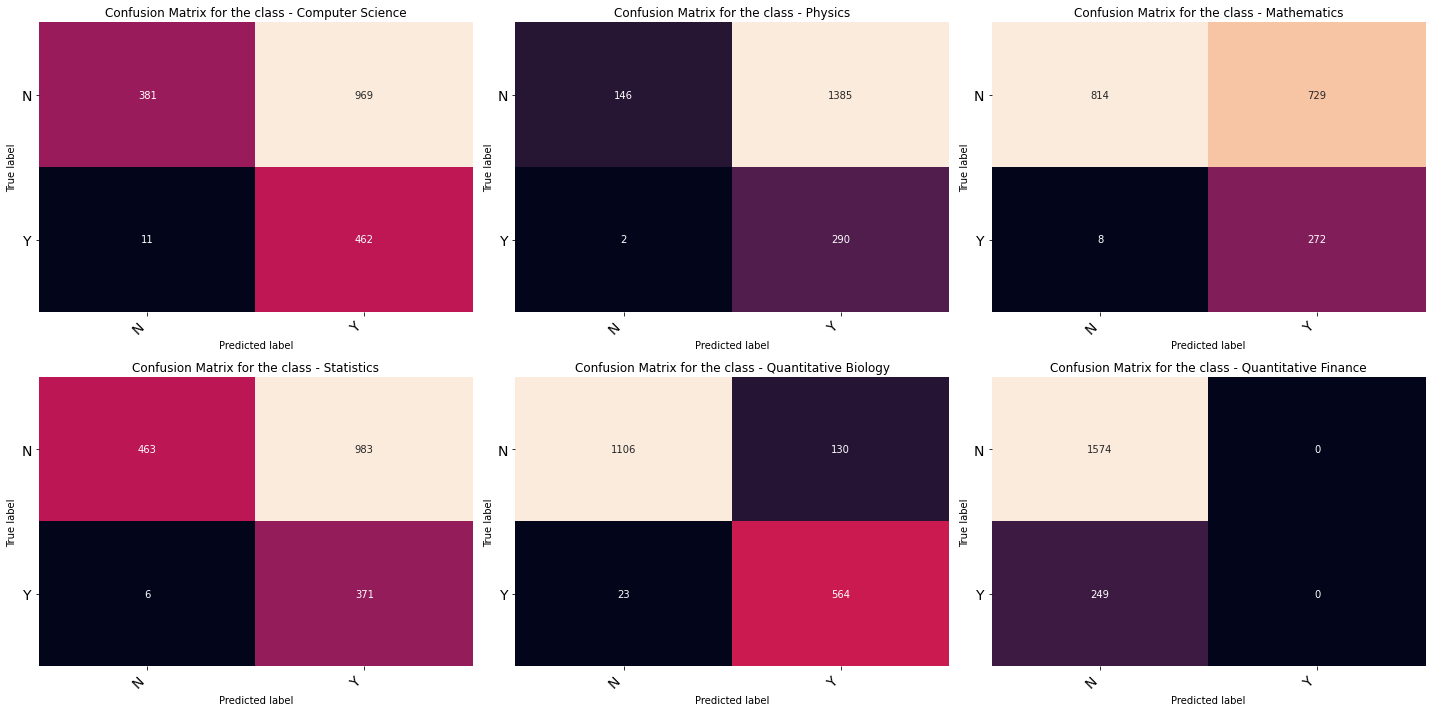

Confusion matrix for Stemming


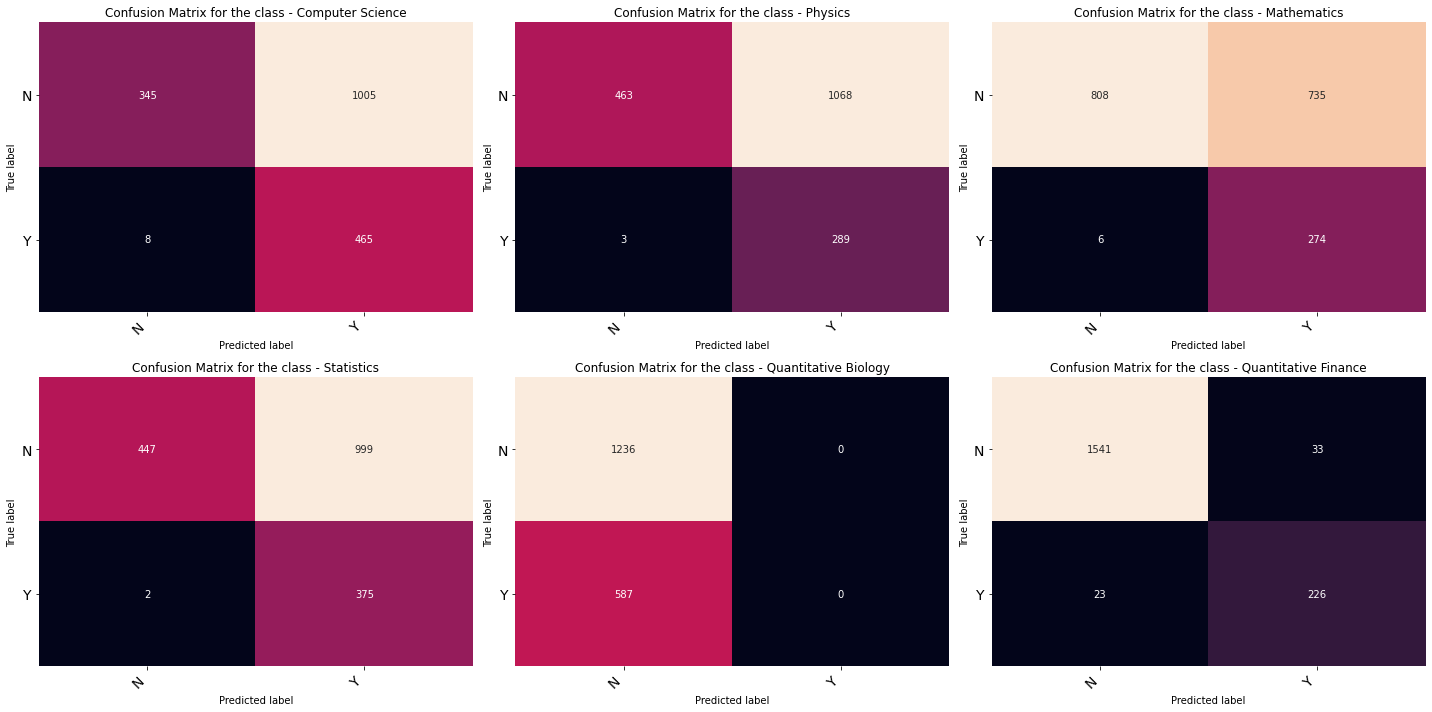

Confusion matrix for Lemmatizing


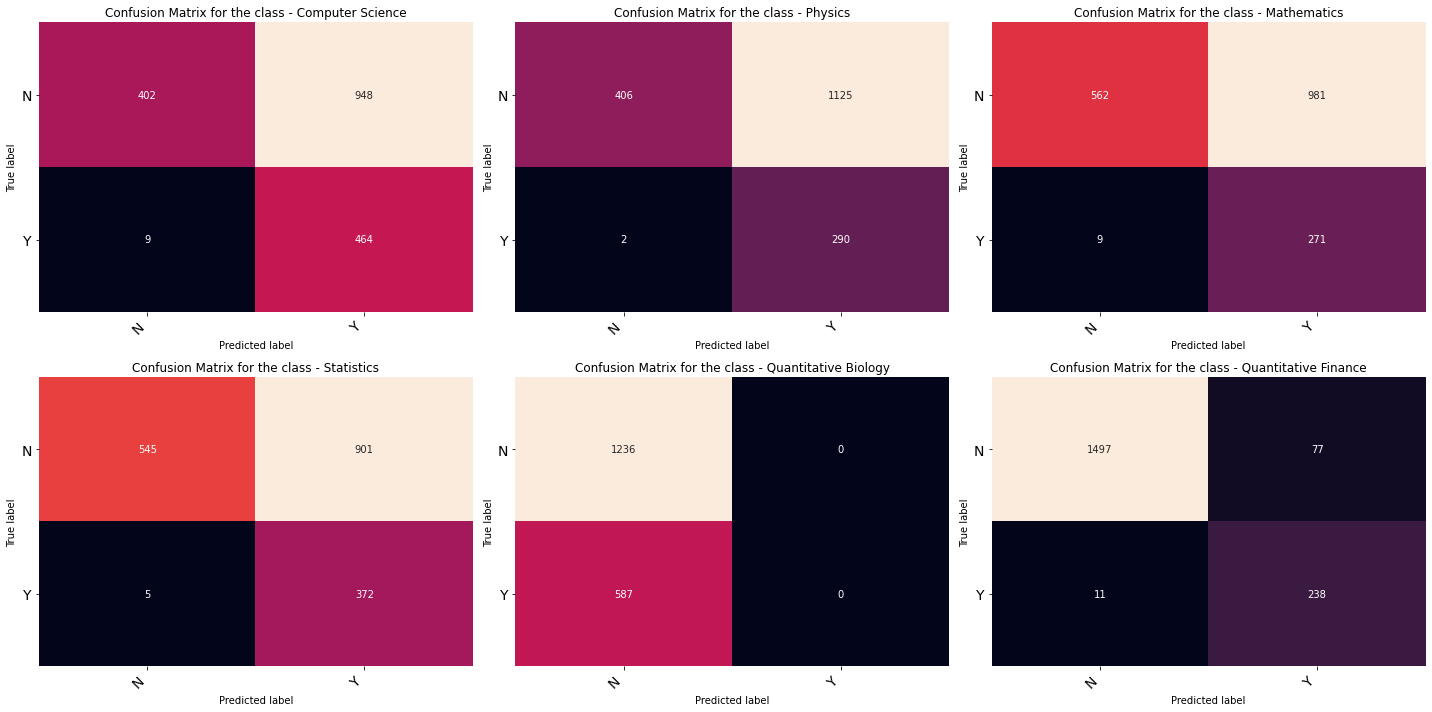

In [26]:
utils.draw_confusion_matrices(y_preds, Ys, classes, threshold, model_names)

ROC curve for No Preprocessing


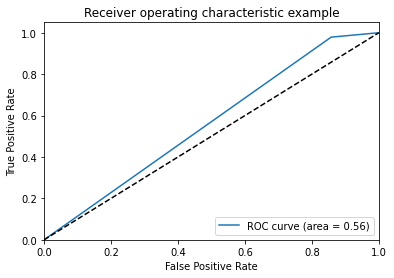

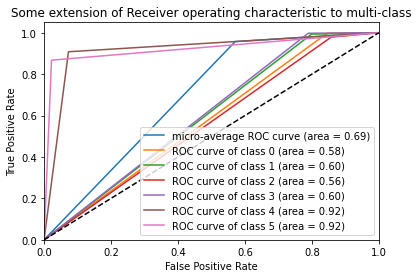

ROC curve for Replacing latex equations


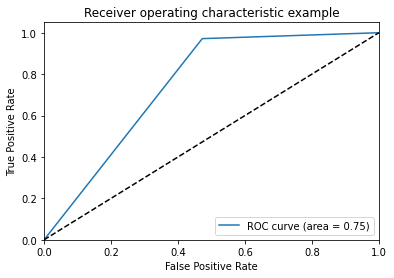

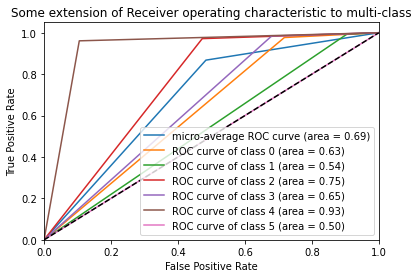

ROC curve for Stemming


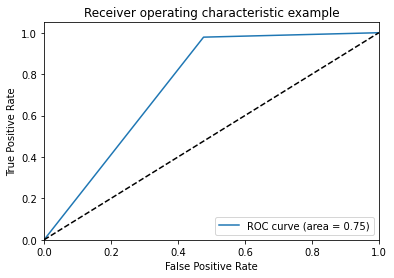

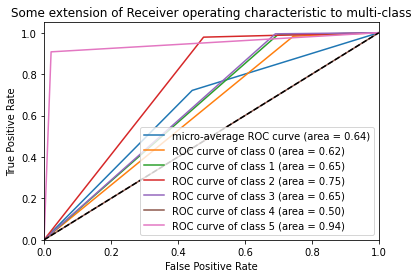

ROC curve for Lemmatizing


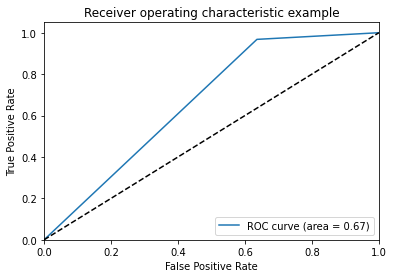

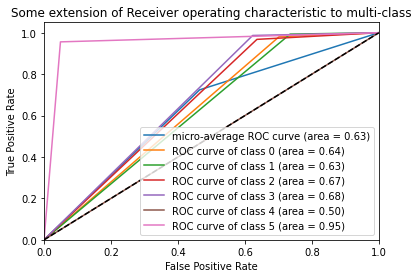

In [27]:
utils.draw_rocs(y_preds, Ys, classes, threshold, model_names)

In [28]:
utils.print_classification_reports(y_preds, Ys, classes, threshold, model_names)

Classification for No Preprocessing  : 
                       precision    recall  f1-score   support

    Computer Science       0.29      1.00      0.45       473
             Physics       0.19      0.99      0.32       292
         Mathematics       0.17      0.98      0.29       280
          Statistics       0.25      1.00      0.40       377
Quantitative Biology       0.86      0.91      0.88       587
Quantitative Finance       0.86      0.87      0.86       249

           micro avg       0.30      0.96      0.46      2258
           macro avg       0.44      0.96      0.53      2258
        weighted avg       0.47      0.96      0.56      2258
         samples avg       0.34      0.96      0.48      2258

Classification for Replacing latex equations  : 
                       precision    recall  f1-score   support

    Computer Science       0.32      0.98      0.49       473
             Physics       0.17      0.99      0.29       292
         Mathematics       0.27      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From the experiment, we are choosing the last setup with the preprocesing pipeline as
* replace latex equation with the word latex
* then lemmatize the input

# Conclusion

The experiment has shown, bearing in mind all the margin of error, replacing latex equations with the word equation and lemmatizing has given the best result. It would be intresting to see what removing all the references([25]) can do.